In [1]:
import os
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
import itertools
from sklearn.utils import resample

In [3]:
from facct22.utils import get_db_con

from facct22.analysis_functions import (
    get_all_decisions, groups, schemas, users, dps, dt, pdr, group_order, colors, 
    assign_conf_mat_cell, _modify_value_and_time, assign_conf_mat_cell, _get_variant_from_random_explainer,
    _remove_duplicates
)

In [4]:
cred_file = '../../conf/credentials.yaml'
engine = get_db_con(cred_file)

In [76]:
def _remove_question_duplicates(group_df):
    """The way we are fetching the records from different schema results in duplicates. Removing them"""
    d = dict()
    group_df['label'].fillna(0, inplace=True)
    
    d['decision'] = group_df['decision'].max()
    d['label'] = group_df['label'].max()
    d['answer'] = group_df['answer'].max()
#     d['answer_id'] = group_df['answer_id'].max()
    d['question'] = group_df['question'].max()
    return pd.Series(d)

In [92]:
# answer_qs = [
# f"""SELECT
# ef.xplz_id,
# an.answer,
# an.answer_id,
# rf.group,
# qu.question,
# qu.question_id,
# us.user_name,
# rf.decision,
# ta.label
# FROM {schema}.explicit_feedback as ef
# LEFT JOIN {schema}.review_feedback rf USING (xplz_id, user_id)
# LEFT JOIN {schema}.users us USING (user_id)
# LEFT JOIN {schema}.answers an USING (answer_id)
# LEFT JOIN {schema}.closed_questions qu USING (question_id)
# LEFT JOIN {schema}.trx_user_assignments ta USING (xplz_id, user_id)
# where us.user_name in {users}
# ORDER BY xplz_id, rf.submission_datetime DESC
# """
# for schema in schemas
# ]

answer_queries = [
f"""SELECT
ef.xplz_id,
an.answer,
an.answer_id,
rf.group,
qu.question,
qu.question_id,
us.user_name,
rf.decision,
ta.label,
ta.label_fields ->> 'type' as trx_type
FROM {schema}.explicit_feedback as ef
LEFT JOIN {schema}.review_feedback rf USING (xplz_id, user_id)
LEFT JOIN {schema}.users us USING (user_id)
LEFT JOIN {schema}.answers an USING (answer_id)
LEFT JOIN {schema}.closed_questions qu USING (question_id)
LEFT JOIN {schema}.trx_user_assignments ta USING (xplz_id, user_id)
where rf.user_name in {users}
ORDER BY xplz_id, rf.submission_datetime DESC
"""
for schema in schemas
]


df_all = pd.concat([pd.read_sql(q, engine) for q in answer_queries])

# print(df_all.head())
df_all['user_name'] = df_all['user_name'].str.split('_').apply(lambda x: '_'.join(x[-1:]) if x is not None else None)

df_all['group'] = df_all.apply(lambda x: _get_variant_from_random_explainer(engine, x), axis=1 )

df_all['group'] = df_all['group'].apply(lambda x: groups[x] if x in groups else x)
# df_all = df_all.groupby(['xplz_id', 'group', 'user_name', 'question_id', "answer_id"]).apply(_remove_question_duplicates).reset_index()


In [99]:
schemas

['ab_server_cmu_share_control',
 'ab_server_cmu_share_explainers',
 'ab_server_cmu_share_random_all',
 'ab_server_cmu_share_random_j',
 'ab_server_cmu_share_random_n',
 'ab_server_cmu_share_random_t']

In [100]:
users

('exp_ns_fa_j',
 'exp_ns_fa_n',
 'exp_ns_fa_t',
 'exp_sc_fa_j',
 'exp_sc_fa_n',
 'exp_sc_fa_t',
 'exp_3_fa_j',
 'exp_3_fa_n',
 'exp_3_fa_t',
 'exp_4_fa_j',
 'exp_4_fa_n',
 'exp_4_fa_t',
 'exp_5_fa_j',
 'exp_5_fa_n',
 'exp_5_fa_t',
 'exp_6_fa_j',
 'exp_6_fa_n',
 'exp_6_fa_t',
 'exp_7_fa_j',
 'exp_7_fa_n',
 'exp_7_fa_t',
 'exp_8_fa_j',
 'exp_8_fa_n',
 'exp_8_fa_t')

In [93]:
questions = df_all.groupby('question_id')

In [94]:
comparisons = [
    ('Data', 'ML Model'),
    ('ML Model', 'LIME'),
    ('ML Model', 'TreeInt'),
    ('ML Model', 'TreeSHAP'),
    ('ML Model', 'Random'),
    ('ML Model', 'Irrelevant'),
    ('Random', 'TreeInt'),
    ('Random', 'TreeSHAP'),
    ('Random', 'LIME'),
    ('Irrelevant', 'TreeInt'),
    ('Irrelevant', 'TreeSHAP'),
    ('Irrelevant', 'LIME'),
    ('Irrelevant', 'Random'),
    ('LIME', 'TreeSHAP'),
    ('LIME', 'TreeInt'),
    ('TreeSHAP', 'TreeInt')
]

In [95]:
def chi_square_test(contingency_table: np.array) -> tuple:
    """ Performs a chi-squared test, given an matrix with the observed values
    (contingency table).

    It is assumed that the rows represent the group and the columns represent
    the classes.

    Parameters
    ----------
    contingency: numpy.array
        Observed frequencies of each group for a given class.

    Return
    ------
    tuple
        Statistic and p-value of the test.
    """
    expected = []
    for j in range(contingency_table.shape[0]):
        expected_line = []
        for i in range(contingency_table.shape[1]):
            frequency = np.sum(contingency_table[:, i]) / np.sum(contingency_table)
            expected_value = frequency * np.sum(contingency_table[j, :])
            expected_line.append(expected_value)
        expected.append(expected_line)
    expected = np.array(expected)
    statistic = np.sum((contingency_table-expected)**2 / expected)
    dof = (contingency_table.shape[0]-1) * (contingency_table.shape[1]-1)
    pvalue = 1 - stats.chi2(df=dof).cdf(statistic)
    return statistic, pvalue

In [96]:
confident_answers = {
    "How confident are you in your classification?": {"I'm sure"},
    "Did you have enough information to make a decision?": {'Absolutely', "Yes, mostly"}
}

# confident_answers = {
#     "How confident are you in your classification?": { "Confident", "I'm sure"},
#     "Did you have enough information to make a decision?": {'Absolutely', "Yes, mostly"}
# }

#### Running the chi squared test

In [97]:
results_dfs = []
p_val_dfs = []

for q, all_groups in questions:
    grp_obj = all_groups.groupby('group')
    contingency = dict()
    for g, df in grp_obj:
        df['confident'] = df.apply(lambda x: 1 if x['answer'] in confident_answers[x['question']] else 0, axis=1)
        val_counts = df['confident'].value_counts().to_dict()
        l = list()
        l.append(val_counts[0]) if 0 in val_counts else l.append(0)
        l.append(val_counts[1]) if 1 in val_counts else l.append(0)
#             l.append(val_counts[0])
#         if 1 in val_counts:
#             l.append(val_counts[1])
        
        contingency[g] = l
    
    
    print('Question: ', all_groups['question'].unique()[0])
    
    l = list()
    for g, freq in contingency.items():
        confidence_rate = freq[1] / np.sum(freq)
        
        d = dict()
        d['group'] = g
        d['confidence_frac'] = confidence_rate
        l.append(d)
        
    df = pd.DataFrame(l).sort_values('confidence_frac', ascending=False)
    results_dfs.append(df)
    
    res = list()
    for comp in comparisons:
        
        contingency_table = [contingency[comp[0]], contingency[comp[1]]]
        
        stat, p_val = chi_square_test(np.array(contingency_table))
        d = dict()
        d['comparison'] = comp
        d['p-val'] = p_val
        
        res.append(d)
        
        if p_val < 0.1:
            print(comp, p_val)
            
    df = pd.DataFrame(res)
    p_val_dfs.append(df)    
    print('---')

/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Question:  How confident are you in your classification?
('ML Model', 'LIME') 0.0
('ML Model', 'TreeInt') 0.0
('ML Model', 'TreeSHAP') 0.0
('ML Model', 'Random') 0.0
('ML Model', 'Irrelevant') 0.0
('Random', 'TreeInt') 0.00022682959441999717
('Random', 'TreeSHAP') 0.05422026950742298
('Random', 'LIME') 1.1115614753087755e-06
('Irrelevant', 'TreeInt') 1.435335802679738e-05
('Irrelevant', 'TreeSHAP') 0.009258482564965309
('Irrelevant', 'LIME') 3.6558825522448046e-08
('LIME', 'TreeSHAP') 0.0002110346686292619
('TreeSHAP', 'TreeInt') 0.027100369155180215
---


/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Question:  Did you have enough information to make a decision?
('Data', 'ML Model') 0.001559042211932038
('ML Model', 'LIME') 7.274134627976991e-08
('ML Model', 'TreeInt') 0.01197676711237472
('ML Model', 'TreeSHAP') 2.037104326235717e-05
('ML Model', 'Random') 0.0
('ML Model', 'Irrelevant') 0.0
('Random', 'TreeInt') 0.0
('Random', 'TreeSHAP') 0.0
('Random', 'LIME') 0.0
('Irrelevant', 'TreeInt') 0.0
('Irrelevant', 'TreeSHAP') 0.0
('Irrelevant', 'LIME') 0.0
('LIME', 'TreeInt') 0.0005570479952421437
('TreeSHAP', 'TreeInt') 0.03484940895474742
---


Text(0.5, 1.0, 'Did you have enough information to make a decision?')

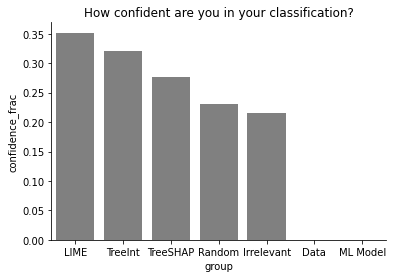

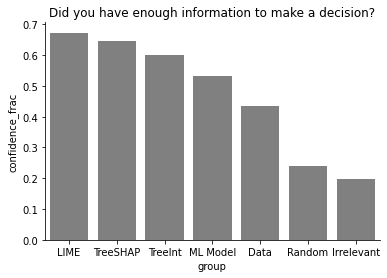

In [98]:
fig, ax = plt.subplots()


sns.barplot(
    data=results_dfs[0],
    x='group',
    y='confidence_frac',
    color='gray',
    ax=ax
)
sns.despine()
ax.set_title('How confident are you in your classification?')

fig, ax = plt.subplots()

sns.barplot(
    data=results_dfs[1],
    x='group',
    y='confidence_frac',
    color='gray',
    ax=ax
)
sns.despine()
ax.set_title('Did you have enough information to make a decision?')

# results_dfs[0]

In [84]:
results_dfs[0].rename(columns={'confidence_frac': 'pct_high_confidence'})

,pct_high_confidence,group
2,0.360000,LIME
5,0.328629,TreeInt
6,0.274000,TreeSHAP
4,0.239919,Random
1,0.220884,Irrelevant
0,0.000000,Data
3,0.000000,ML Model


In [ ]:
results_dfs[0].rename(columns={'confidence_frac': 'pct_high_confidence'})

In [56]:

p_val_dfs[0]

,comparison,p-val
0,"(Data, ML Model)",0.098609
1,"(ML Model, LIME)",0.015431
2,"(ML Model, TreeInt)",0.388882
3,"(ML Model, TreeSHAP)",0.019226
4,"(ML Model, Random)",0.025491
5,"(ML Model, Irrelevant)",0.221009
6,"(Random, TreeInt)",0.001981
7,"(Random, TreeSHAP)",0.000005
8,"(Random, LIME)",0.000003
9,"(Irrelevant, TreeInt)",0.036965
